# 1.1 A Regression Example

### Setup

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

Load the data

In [3]:
kidney = pd.read_csv("../data/kidney.txt", delimiter=" ")

In [4]:
kidney.head()

,age,tot
0,18,2.44
1,19,3.86
2,19,-1.22
3,20,2.30
4,21,0.98


### Ordinary least squares regression model

Fit the model

In [5]:
model = smf.ols(formula="tot ~ age", data=kidney)
results = model.fit()

Create predictions for the regression line

In [6]:
sorted_kidney = kidney.sort_values("age")
tot_pred = results.predict(sorted_kidney)

Get predictions and standard error for ages 20, 30, ..., 80

In [7]:
decades = pd.DataFrame({"age": range(20, 90, 10)})

In [8]:
pred = results.get_prediction(decades)
pred_info = pred.summary_frame()
pred_info.index = decades.age

In [9]:
pred_info

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
age,,,,,,
20,1.288258,0.206648,0.880048,1.696469,-2.292802,4.869319
30,0.502374,0.154965,0.196259,0.808490,-3.068490,4.073238
40,-0.283510,0.147398,-0.574678,0.007659,-3.853123,3.286104
50,-1.069394,0.189314,-1.443363,-0.695425,-4.646713,2.507926
60,-1.855278,0.257595,-2.364127,-1.346429,-5.449202,1.738646
70,-2.641162,0.336559,-3.305996,-1.976329,-6.260467,0.978142
80,-3.427046,0.420226,-4.257155,-2.596937,-7.080325,0.226232


Collect info for standard error lines

In [10]:
se_lines = LineCollection(
    [
        [[age, pred - 2 * se], [age, pred + 2 * se]]
        for age, pred, se in zip(pred_info.index, pred_info["mean"], pred_info["mean_se"])
    ],
    color="k"
)

### Figure 1.1

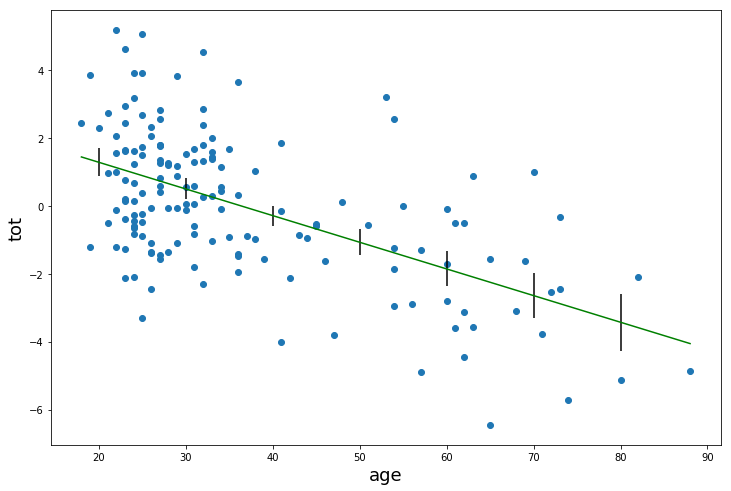

In [11]:
fig, ax = plt.subplots(figsize=(12,8))

ax.scatter(kidney.age, kidney.tot)
ax.plot(sorted_kidney.age, tot_pred, color="g")
ax.add_collection(se_lines)

ax.set_xlabel("age", size=18)
ax.set_ylabel("tot", size=18);

### Lowess model

In [12]:
from statsmodels.nonparametric.smoothers_lowess import lowess

Create main lowess predictions

The `lowess` function returns an N x 2 Numpy array with x-values in the 0th column and y-values (fit values) in the 1st column

In [13]:
low_preds = lowess(kidney.tot, kidney.age, frac=1/3.0)

In [14]:
low_preds[:5]

array([[18.        ,  2.24792193],
       [19.        ,  1.95243881],
       [19.        ,  1.95243881],
       [20.        ,  1.65762652],
       [21.        ,  1.36364605]])

Create 250 bootstrap samples of the lowess predictions

In [15]:
low_boots = []
for i in range(250):
    boot_data = kidney.sample(n=kidney.shape[0], replace=True)
    new_preds = lowess(boot_data.tot, boot_data.age, frac=1/3.0)
    low_boots.append(new_preds)

Get bootstrap standard deviation as an estimate of standard error

As mentioned above, the return value from `lowess` is an array of input x-values (age) and fit lowess values (tot). To get the fit lowess value at a particular age, we need to interpolate or extrapolate from the ages in the returned array. We can't assume an age value we're interested in is one of the input x-values

In [16]:
from scipy.interpolate import interp1d

In [17]:
ages = np.array(list(range(20, 90, 10)))

In [18]:
# interpolate lowess predictions for age = 20, 30, ..., 80
dec_preds = np.zeros((7, 250))
for i, pred in enumerate(low_boots):
    # interp1d seems to have trouble with non-unique values
    pred = np.unique(pred, axis=0)
    # create an interpolator and collect each lowess's predictions
    interpolate = interp1d(pred[:, 0], pred[:, 1], fill_value="extrapolate", assume_sorted=True)
    dec_preds[:, i] = interpolate(ages)

# get standard deviation for each age
var = np.var(dec_preds, axis=1, ddof=1)
sds = np.sqrt(var)

Collect info for standard error lines

In [19]:
# interpolate/predict from the original lowess predictions
interpolate = interp1d(
    low_preds[:, 0],
    low_preds[:, 1],
    fill_value="extrapolate",
    assume_sorted=True
)

se_lines = LineCollection(
    [
        [[age, interpolate(age) - 2 * se], [age, interpolate(age) + 2 * se]]
        for age, se in zip(ages, sds)
    ],
    color="k"
)

### Figure 1.2

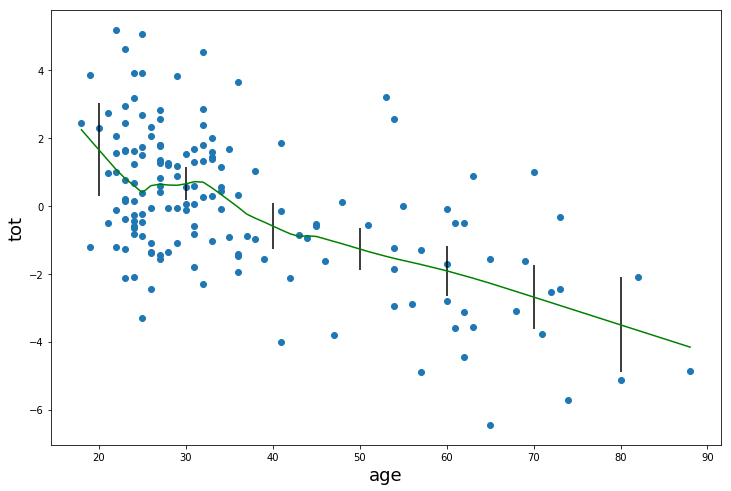

In [20]:
fig, ax = plt.subplots(figsize=(12,8))

ax.scatter(kidney.age, kidney.tot)
ax.plot(low_preds[:, 0], low_preds[:, 1], color="g")
ax.add_collection(se_lines)

ax.set_xlabel("age", size=18)
ax.set_ylabel("tot", size=18);

### Table 1.1

In [21]:
tmplt = " {:>5.2f} {:>5.2f} {:>5.2f} {:>5.2f} {:>5.2f} {:>5.2f} {:>5.2f}"
print("                                           age")
print("                        -----------------------------------------")
print("                          20    30    40    50    60    70    80")
print("-" * 65)
print(" 1. linear regression " + tmplt.format(*pred_info["mean"]))
print(" 2. std error         " + tmplt.format(*pred_info["mean_se"]))
print()
print(" 3. lowess            " + tmplt.format(*interpolate(ages)))
print(" 4. boostrap std error" + tmplt.format(*sds))

                                           age
                        -----------------------------------------
                          20    30    40    50    60    70    80
-----------------------------------------------------------------
 1. linear regression   1.29  0.50 -0.28 -1.07 -1.86 -2.64 -3.43
 2. std error           0.21  0.15  0.15  0.19  0.26  0.34  0.42

 3. lowess              1.66  0.65 -0.59 -1.27 -1.91 -2.68 -3.50
 4. boostrap std error  0.69  0.24  0.34  0.31  0.37  0.47  0.70


We expect the boostrap standard errors to be close to the book's values, but not exactly the same, due to randomness and the fact that only 250 bootstrap samples were used

### Figure 1.3

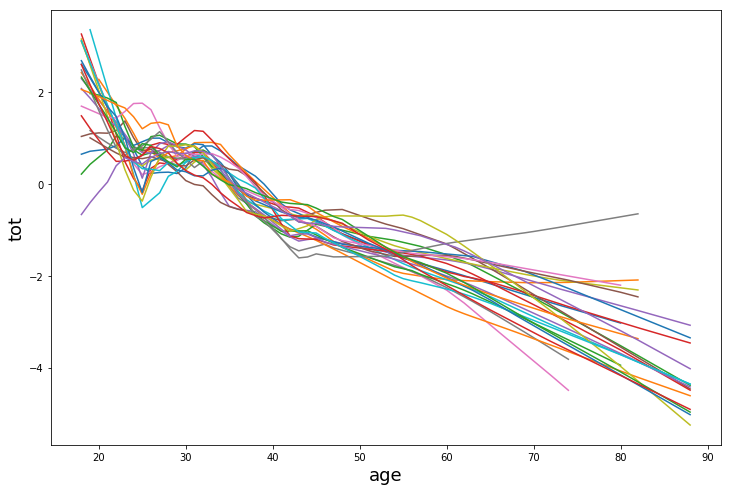

In [22]:
fig, ax = plt.subplots(figsize=(12,8))

for preds in low_boots[:25]:
    ax.plot(preds[:, 0], preds[:, 1])

ax.set_xlabel("age", size=18)
ax.set_ylabel("tot", size=18);